In [1]:
import os, sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import MaaSSim

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
#!pip install MaaSSim
import MaaSSim.utils
import logging
from dotmap import DotMap
import MaaSSim.simulators
from MaaSSim.data_structures import structures as inData
from MaaSSim.day_to_day import driver_opt_out, S_driver_opt_out, traveller_opt_out, S_traveller_opt_out, rh_U_func
from MaaSSim.day_to_day import traveller_opt_out
from MaaSSim.day_to_day import RL_d2d_kpi_veh
from MaaSSim.day_to_day import RL_d2d_kpi_pax

In [4]:
import osmnx as ox
import networkx as nx
import random
import math
import pandas as pd
import matplotlib.pyplot as plt          
import numpy as np
import seaborn as sns
# from statsmodels.tsa.stattools import adfuller

In [5]:
# the setting for TRB results do not delete
params = MaaSSim.utils.get_config('glance.json')
# params.city = "Amsterdam, Netherlands"
# params.paths.G = "../../data/graphs/Amsterdam.graphml"
# params.paths.skim = "../../data/graphs/Amsterdam.csv"
params.vehicle_fixed_positions = True
params.times.patience = 600 #second
params.dist_threshold = 20000 #meter
params.dist_threshold_min = 2000 #meter

params.d2d.probabilistic = True
params.d2d.heterogeneous = False
params.d2d.ini_att = 0.5
params.d2d.B_income = 1
params.d2d.fuel_cost = 0.25 #euro/km

params.d2d.B_inveh_time = 1
params.d2d.B_exp_time = 2 #1.5 in oded's paper
params.PT_fare = 1 ## euro
params.PT_avg_speed = 6

params.nPM = 1 # number of platforms. platform id starts from 1
params.platforms.base_fare = 1.4 #euro
params.platforms.fare = float(1.20) #euro/km
params.platforms.min_fare = float(2) # euro
params.platforms.comm_rate = float(0.10)
params.platforms.discount = float(0.40)
params.platforms["isMarketingOn"] = True

params.d2d.learning_d = 1 
params.d2d.B_Experience = 0.8
params.d2d.B_WOM = 0.18
params.d2d.B_Marketing = 0.02
params.d2d.diffusion_speed = 10/100 # speed for M is twice greater than WOM.
params.d2d.m = 5
params.d2d.Eini_att = 0.01
params.d2d.adj_s = 2
params.VoT = 10.63 # value of time per hour
params.assert_me = False
params.paths.requests = 'Nootdorp_requests.csv'

params.nP = 100
params.nV = 10
params.nD = 20
params.simTime = 4
params.d2d.res_wage = params.simTime*10.63 #euro

In [6]:
params.city

#wazne modyfikacje i dodane funkcjnalnosci w innych miejscach:

#prep_RL_simulate - funkcja sluzaca do przygotowania symulacji
#next_RL_iter - funkcja wykonujaca nastepny dzien symulacji
#RL_d2d_kpi_veh - funkcja dla kpi_veh, taka jak dla d2d_kpi_veh tylko obsluguje marketing w zaleznosci od parametru isMarketingOn
#RL_d2d_kpi_pax - funkcja dla kpi_pax, taka jak dla d2d_kpi_pax tylko obsluguje marketing w zaleznosci od parametru isMarketingOn
#generate_platforms - zmodyfikowane, aby obsługiwało parameter isMarketingOn

'Nootdorp, Netherlands'

In [7]:
# sim = MaaSSim.simulators.simulate(params=params, logger_level=logging.WARNING)
# sim_alter = MaaSSim.simulators.simulate(params=params, f_driver_out=S_driver_opt_out,f_trav_out=S_traveller_opt_out,
#                                   kpi_veh=d2d_kpi_veh,kpi_pax=d2d_kpi_pax, logger_level=logging.WARNING)

# sim = MaaSSim.simulators.simulate(params=params,kpi_pax=d2d_kpi_pax, logger_level=logging.WARNING)

sim = MaaSSim.simulators.prep_RL_simulate(params=params, f_driver_out=S_driver_opt_out,f_trav_out=S_traveller_opt_out,
                                  kpi_veh=RL_d2d_kpi_veh,kpi_pax=RL_d2d_kpi_pax, logger_level=logging.WARNING)
for i in range(params.nD):
    sim = MaaSSim.simulators.next_RL_iter(sim, i)

prep_RL_simulate 1
This simulation uses albatros data
1
2
3
4
4.2
4.3
4.4
4.5
4.6
5
16-12-22 15:40:23-WARNING-Setting up 4h simulation at 2022-12-16 13:53:40 for 10 vehicles and 100 passengers in Nootdorp, Netherlands
prep_RL_simulate 2
16-12-22 15:40:23-WARNING-simulation time 0.2 s
DotMap(base_fare=1.4, fare=1.2, min_fare=2.0, comm_rate=0.1, discount=0.4, isMarketingOn=True, loc=DotMap(1=DotMap())) DotMap()
16-12-22 15:40:24-WARNING-simulation time 0.2 s
DotMap(base_fare=1.4, fare=1.2, min_fare=2.0, comm_rate=0.1, discount=0.4, isMarketingOn=True, loc=DotMap(1=DotMap())) DotMap()
16-12-22 15:40:25-WARNING-simulation time 0.2 s
DotMap(base_fare=1.4, fare=1.2, min_fare=2.0, comm_rate=0.1, discount=0.4, isMarketingOn=True, loc=DotMap(1=DotMap())) DotMap()
16-12-22 15:40:25-WARNING-simulation time 0.2 s
DotMap(base_fare=1.4, fare=1.2, min_fare=2.0, comm_rate=0.1, discount=0.4, isMarketingOn=True, loc=DotMap(1=DotMap())) DotMap()
16-12-22 15:40:26-WARNING-simulation time 0.3 s
DotMap(base

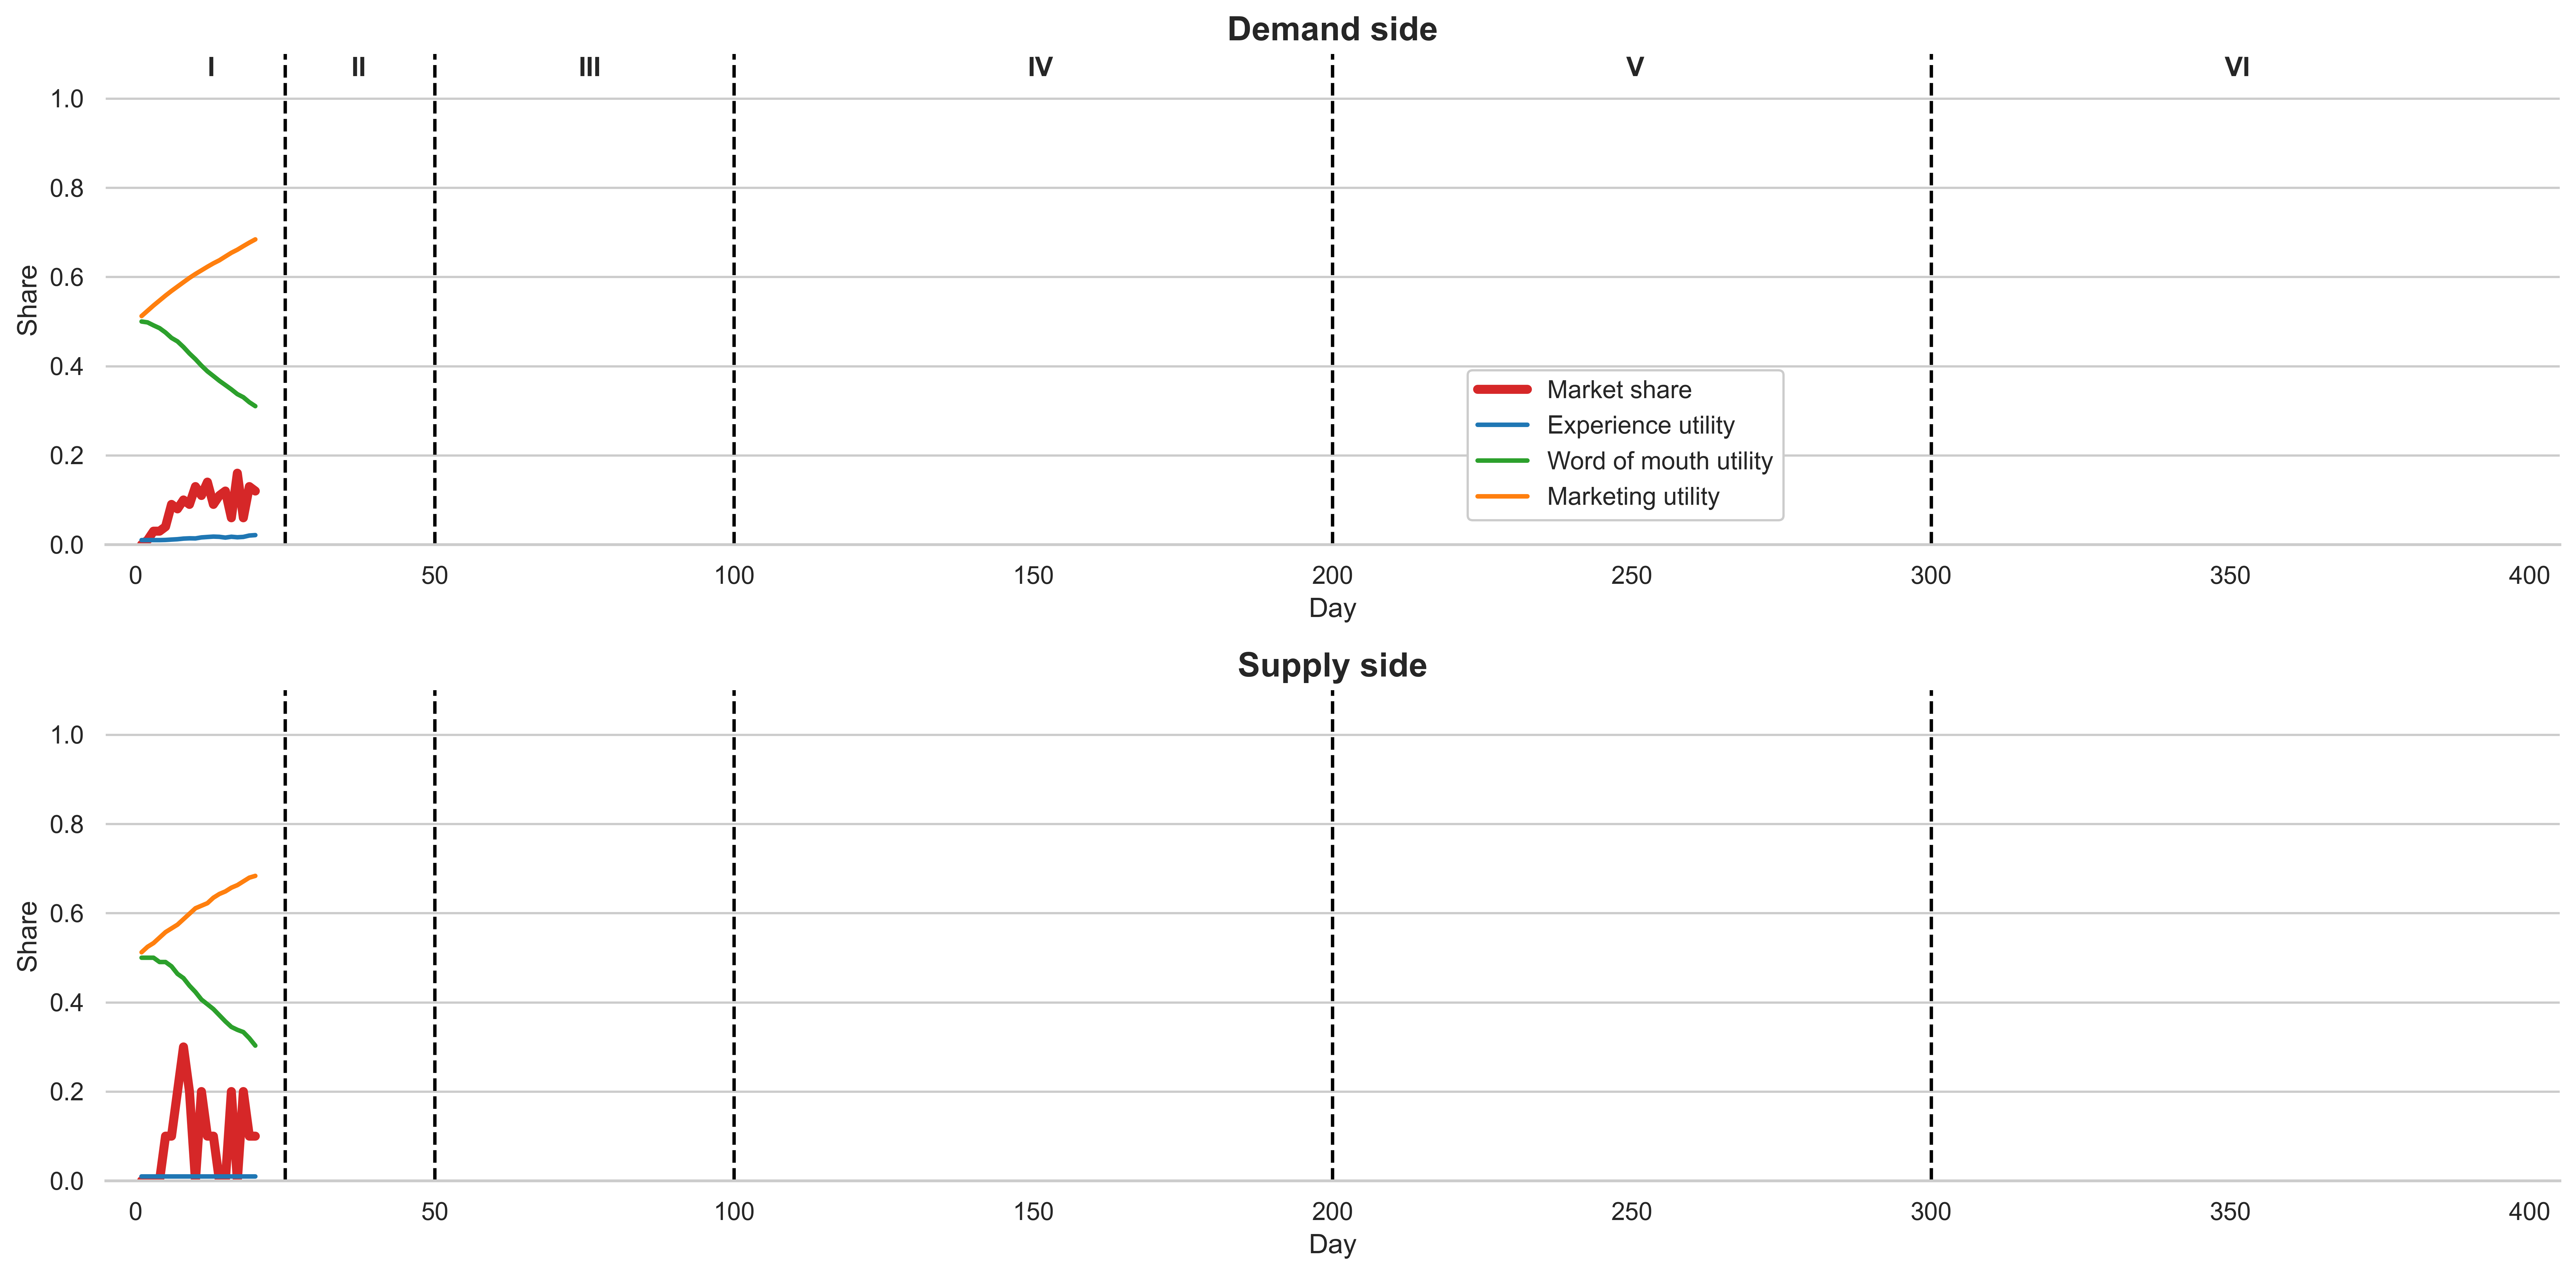

In [8]:
def printSim(sim):
    # with S-shaped curve nD=200 nP=2000 nV=200, with increased passenger sensitivity to changes in system
    sns.set(rc={"figure.dpi":500, 'savefig.dpi':500})
    sns.set(palette='tab10',font_scale=1)#, rc={'axes.facecolor':'lightblue', 'figure.facecolor':'lightgreen'},)
    sns.set_style('whitegrid')
    fig, ax = plt.subplots(nrows=2, figsize=(16,8))
    # plt.subplots_adjust(wspace=0.3, hspace=0.4)
    sns.despine(left=True)

    for ax_n in [0,1]:
        
        x = []; ye = []; ym = []; yw = []; yms = []
        if ax_n==0:
            for d in range(0,sim.params.nD):
                yw.append(sim.res[d].pax_exp.WOM_U.mean())
                ym.append(sim.res[d].pax_exp.MARKETING_U.mean())
                ye.append(sim.res[d].pax_exp.EXPERIENCE_U.mean())
                yms.append(sim.res[d].pax_exp.OUT.value_counts().get(False, 0)/params.nP)
                
        if ax_n==1:
            for d in range(0,sim.params.nD):
                yw.append(sim.res[d].veh_exp.WOM_U.mean())
                ym.append(sim.res[d].veh_exp.MARKETING_U.mean())
                ye.append(sim.res[d].veh_exp.EXPERIENCE_U.mean())
                yms.append(sim.res[d].veh_exp.OUT.value_counts().get(False, 0)/params.nV)
        
        lx = [i for i in range(1,len(ye)+1)]
        sns.lineplot(x=lx, y=yms, label = 'Market share', color='C3', lw=4, ax=ax[ax_n])#, marker='o')
        sns.lineplot(x=lx, y=ye, label = 'Experience utility', color='C0', lw=2, ax=ax[ax_n])#, marker='o')
        sns.lineplot(x=lx, y=yw, label = 'Word of mouth utility', color='C2', lw=2, ax=ax[ax_n])#, marker='o')
        sns.lineplot(x=lx, y=ym, label = 'Marketing utility', color='C1', lw=2, ax=ax[ax_n])#, marker='o')
    
        ax[ax_n].vlines([25, 50, 100, 200, 300], 0, 1.1, linestyles='dashed', colors='black')
        ax[ax_n].grid(axis='x')
        ax[ax_n].set(xlabel='Day', ylabel='Share', ylim=(0,1.1),  xlim=(-5,405))
        
    ax[0].set_title('Demand side',fontweight='bold', loc='center',fontsize=15);ax[1].set_title('Supply side',fontweight='bold', loc='center',fontsize=15)
    ax[0].legend(frameon=True,framealpha=1, loc=(0.555,0.05))#,  bbox_to_anchor=(0.75, 1.24), ncol=4)
    ax[1].get_legend().set_visible(False)
    for i in range(0,6):
        value = ['I','II','III','IV','V','VI']
        coords = [(12,1.05),(36,1.05),(74,1.05),(149,1.05),(249,1.05),(349,1.05)]
        ax[0].annotate(value[i], xy =coords[i], fontweight='bold')

    # plt.yticks([0,1])

    plt.tight_layout()
    # plt.savefig('Fig1.png')

printSim(sim)

In [9]:
x = []
ypr = []

for d in range(0,sim.params.nD):
    df = sim.res[d].pax_exp
    profit = df[df.OUT==False].plat_profit.sum()
    marketing_costs = 0.5
    profit -= marketing_costs*(sim.params.nP + sim.params.nV)
    print(profit)
# x = [i for i in range(1,len(ypr)+1)]
ypr

-55.0
-56.68936
-59.17456
-58.84732
-60.45064
-67.0798
-66.80884
-69.6166
-68.92624
-75.54472
-70.25476
-74.32996
-67.30984000000001
-69.74716000000001
-72.1234
-63.06076
-78.36496
-63.10072
-72.98692
-70.98652


[]

In [10]:
import itertools
import matplotlib
import matplotlib.style
import numpy as np
import pandas as pd
import sys
  
  
from collections import defaultdict
# import plotting
  
matplotlib.style.use('ggplot')

In [ ]:
# 100 iteracji 100-dniowych symulacji
# uzyty algorytm: q-learning
# epsilon spada w dol: najpierw bardziej eksplorujemy, pozniej bardziej eksploitujemy
# stan: krotka (dzien, zarobek wczoraj - bez odjecia kosztu marketingu, czy wlaczony marketing, czy wlaczony tryb discount, czy wlaczony tryb greedy)
# akcje: 8 akcji - kombinacja 3 akcji true/false: 1. czy wlaczony marketing, czy wlaczony tryb discount, czy wlaczony tryb greedy
# rezultat: algorytm sie nauczyl zeby zawsze wykonywac akcje 0: (false, false, false)
# marketing wydaje sie za drogi na taka symulacje (ustawiony na 0.10$ na osobe)

In [11]:
class UberEnv:
    def __init__(self) -> None:
        self.action_space = DotMap({})
        self.action_space['n'] = 2**3

    def reset(self):
        # the setting for TRB results do not delete
        params = MaaSSim.utils.get_config('glance.json')
        params.vehicle_fixed_positions = True
        params.times.patience = 600 #second
        params.dist_threshold = 20000 #meter
        params.dist_threshold_min = 2000 #meter

        params.d2d.probabilistic = True
        params.d2d.heterogeneous = False
        params.d2d.ini_att = 0.5
        params.d2d.B_income = 1
        params.d2d.fuel_cost = 0.25 #euro/km

        params.d2d.B_inveh_time = 1
        params.d2d.B_exp_time = 2 #1.5 in oded's paper
        params.PT_fare = 1 ## euro
        params.PT_avg_speed = 6

        params.nPM = 1 # number of platforms. platform id starts from 1
        params.platforms.base_fare = 1.4 #euro
        params.platforms.fare = float(1.20) #euro/km
        params.platforms.min_fare = float(2) # euro
        params.platforms.comm_rate = float(0.10)
        params.platforms.discount = float(0.0)
        params.platforms["isMarketingOn"] = True

        params.d2d.learning_d = 1 
        params.d2d.B_Experience = 0.8
        params.d2d.B_WOM = 0.18
        params.d2d.B_Marketing = 0.02
        params.d2d.diffusion_speed = 10/100 # speed for M is twice greater than WOM.
        params.d2d.m = 5
        params.d2d.Eini_att = 0.01
        params.d2d.adj_s = 2
        params.VoT = 10.63 # value of time per hour
        params.assert_me = False
        params.paths.requests = 'Nootdorp_requests.csv'

        params.nP = 100
        params.nV = 10
        params.nD = 100
        params.simTime = 4
        params.d2d.res_wage = params.simTime*10.63 #euro

        sim = MaaSSim.simulators.prep_RL_simulate(params=params, f_driver_out=S_driver_opt_out,f_trav_out=S_traveller_opt_out,
                                  kpi_veh=RL_d2d_kpi_veh,kpi_pax=RL_d2d_kpi_pax, logger_level=logging.WARNING)
        self.sim = sim
        self.day = 0
        # self.state = (0, 0)

        return (0, 0, True, False, False)

    def step(self, action):
        isMarketingOn = bool((action >> 2) % 2)
        discounted = bool((action >> 1) % 2)
        greedy = bool((action >> 0) % 2)
        # print( self.sim.params.platforms.isMarketingOn, self.sim.params.platforms.discount, self.sim.params.platforms.comm_rate)
        # print(action, isMarketingOn, discounted, greedy)
        self.sim.params.platforms.isMarketingOn = isMarketingOn
        self.sim.params.platforms.discount = float(0.40) if discounted else float(0.00)
        self.sim.params.platforms.comm_rate = float(0.50) if greedy else float(0.10)

        self.sim.params.platforms.loc[1].isMarketingOn = isMarketingOn
        self.sim.params.platforms.loc[1].discount = float(0.40) if discounted else float(0.00)
        self.sim.params.platforms.loc[1].comm_rate = float(0.50) if greedy else float(0.10)

        self.sim = MaaSSim.simulators.next_RL_iter(self.sim, self.day)

        df = self.sim.res[self.day].pax_exp
        last_day_rev = df[df.OUT==False].plat_profit.sum()
        marketing_costs = 0.1
        last_day_profit = last_day_rev - (marketing_costs*(self.sim.params.nP + self.sim.params.nV)) if isMarketingOn else 0

        self.day += 1
        return(self.day, last_day_rev, isMarketingOn, discounted, greedy), last_day_profit, (self.day == self.sim.params.nD), True



env = UberEnv()

bool((4 >> 2) % 2)

True

In [12]:
def createEpsilonGreedyPolicy(Q, num_actions):
    """
    Creates an epsilon-greedy policy based
    on a given Q-function and epsilon.
       
    Returns a function that takes the state
    as an input and returns the probabilities
    for each action in the form of a numpy array 
    of length of the action space(set of possible actions).
    """
    def policyFunction(state, epsilon):
   
        Action_probabilities = np.ones(num_actions,
                dtype = float) * epsilon / num_actions
                  
        best_action = np.argmax(Q[state])
        Action_probabilities[best_action] += (1.0 - epsilon)
        return Action_probabilities
   
    return policyFunction

In [13]:
def qLearning(env, num_episodes, discount_factor = 1.0,
                            alpha = 0.6, epsilon = 0.1):
    """
    Q-Learning algorithm: Off-policy TD control.
    Finds the optimal greedy policy while improving
    following an epsilon-greedy policy"""
       
    # Action value function
    # A nested dictionary that maps
    # state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
   
    # Keeps track of useful statistics
    # stats = plotting.EpisodeStats(
    #     episode_lengths = np.zeros(num_episodes),
    #     episode_rewards = np.zeros(num_episodes))
    stats = None
    eps = 1.0   
       
    # Create an epsilon greedy policy function
    # appropriately for environment action space
    policy = createEpsilonGreedyPolicy(Q, env.action_space.n)
       
    # For every episode
    for ith_episode in range(num_episodes):
           
        # Reset the environment and pick the first action
        state = env.reset()
           
        for t in itertools.count():
               
            # get probabilities of all actions from current state
            action_probabilities = policy(state, eps)
   
            # choose action according to 
            # the probability distribution
            action = np.random.choice(np.arange(
                      len(action_probabilities)),
                       p = action_probabilities)
   
            # take action and get reward, transit to next state
            next_state, reward, done, _ = env.step(action)
   
            # Update statistics
            # stats.episode_rewards[ith_episode] += reward
            # stats.episode_lengths[ith_episode] = t
               
            # TD Update
            best_next_action = np.argmax(Q[next_state])    
            td_target = reward + discount_factor * Q[next_state][best_next_action]
            td_delta = td_target - Q[state][action]
            Q[state][action] += alpha * td_delta
   
            # done is True if episode terminated   
            if done:
                break
                   
            state = next_state

        eps *= 0.97
       
    return Q, stats

In [14]:
Q, stats = qLearning(env, 100)

prep_RL_simulate 1
This simulation uses albatros data
1
2
3
4
4.2
4.3
4.4
4.5
4.6
5
16-12-22 15:40:48-WARNING-Setting up 4h simulation at 2022-12-16 13:43:54 for 10 vehicles and 100 passengers in Nootdorp, Netherlands
prep_RL_simulate 2
16-12-22 15:40:49-WARNING-simulation time 0.2 s
DotMap(base_fare=1.4, fare=1.2, min_fare=2.0, comm_rate=0.1, discount=0.4, isMarketingOn=True, loc=DotMap(1=DotMap(isMarketingOn=True, discount=0.4, comm_rate=0.1))) DotMap(isMarketingOn=True, discount=0.4, comm_rate=0.1)
16-12-22 15:40:50-WARNING-simulation time 0.2 s
DotMap(base_fare=1.4, fare=1.2, min_fare=2.0, comm_rate=0.1, discount=0.4, isMarketingOn=True, loc=DotMap(1=DotMap(isMarketingOn=True, discount=0.4, comm_rate=0.1))) DotMap(isMarketingOn=True, discount=0.4, comm_rate=0.1)
16-12-22 15:40:50-WARNING-simulation time 0.2 s
DotMap(base_fare=1.4, fare=1.2, min_fare=2.0, comm_rate=0.5, discount=0.4, isMarketingOn=True, loc=DotMap(1=DotMap(isMarketingOn=True, discount=0.4, comm_rate=0.5))) DotMap(is

In [15]:
plotting.plot_episode_stats(stats)

NameError: name 'plotting' is not defined

In [16]:
Q

defaultdict(<function __main__.qLearning.<locals>.<lambda>()>,
            {(0,
              0,
              True,
              False,
              False): array([  0.        ,   0.        ,   0.        ,   0.        ,
                    -10.99711642, -10.88736   , -10.88736   ,  -9.24      ]),
             (1,
              0.0,
              True,
              True,
              False): array([ 0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
                    -8.8653312, -8.591592 ,  0.       ]),
             (2,
              -3.3193200000000003,
              True,
              True,
              False): array([ 0.      ,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ,
                     0.      , -8.344704]),
             (3,
              -2.90784,
              True,
              True,
              True): array([0., 0., 0., 0., 0., 0., 0., 0.]),
             (4,
              -4.4816400000000005,
              False,
              True,
         

In [19]:

eps = 0 ## test Q table
policy = createEpsilonGreedyPolicy(Q, env.action_space.n)
state = env.reset()
        
for t in itertools.count():         
    # get probabilities of all actions from current state
    action_probabilities = policy(state, eps)

    # choose action according to 
    # the probability distribution
    action = np.random.choice(np.arange(
                len(action_probabilities)),
                p = action_probabilities)

    # take action and get reward, transit to next state
    next_state, reward, done, _ = env.step(action)

    # done is True if episode terminated
    if done:
        break
            
    state = next_state
    print(state)

This simulation uses albatros data
16-12-22 20:02:56-WARNING-Setting up 4h simulation at 2022-12-16 18:12:40 for 10 vehicles and 100 passengers in Nootdorp, Netherlands
16-12-22 20:02:56-WARNING-simulation time 0.2 s
(1, 0.0, False, False, False)
16-12-22 20:02:57-WARNING-simulation time 0.2 s
(2, 0.8693199999999999, False, False, False)
16-12-22 20:02:58-WARNING-simulation time 0.3 s
(3, 1.98344, False, False, False)
16-12-22 20:02:59-WARNING-simulation time 0.2 s
(4, 0.0, False, False, False)
16-12-22 20:02:59-WARNING-simulation time 0.2 s
(5, 1.8112400000000002, False, False, False)
16-12-22 20:03:00-WARNING-simulation time 0.3 s
(6, 6.6844, False, False, False)
16-12-22 20:03:01-WARNING-simulation time 0.3 s
(7, 2.14852, False, False, False)
16-12-22 20:03:02-WARNING-simulation time 0.2 s
(8, 3.59068, False, False, False)
16-12-22 20:03:03-WARNING-simulation time 0.4 s
(9, 3.9268, False, False, False)
16-12-22 20:03:03-WARNING-simulation time 0.2 s
(10, 4.96528, False, False, False

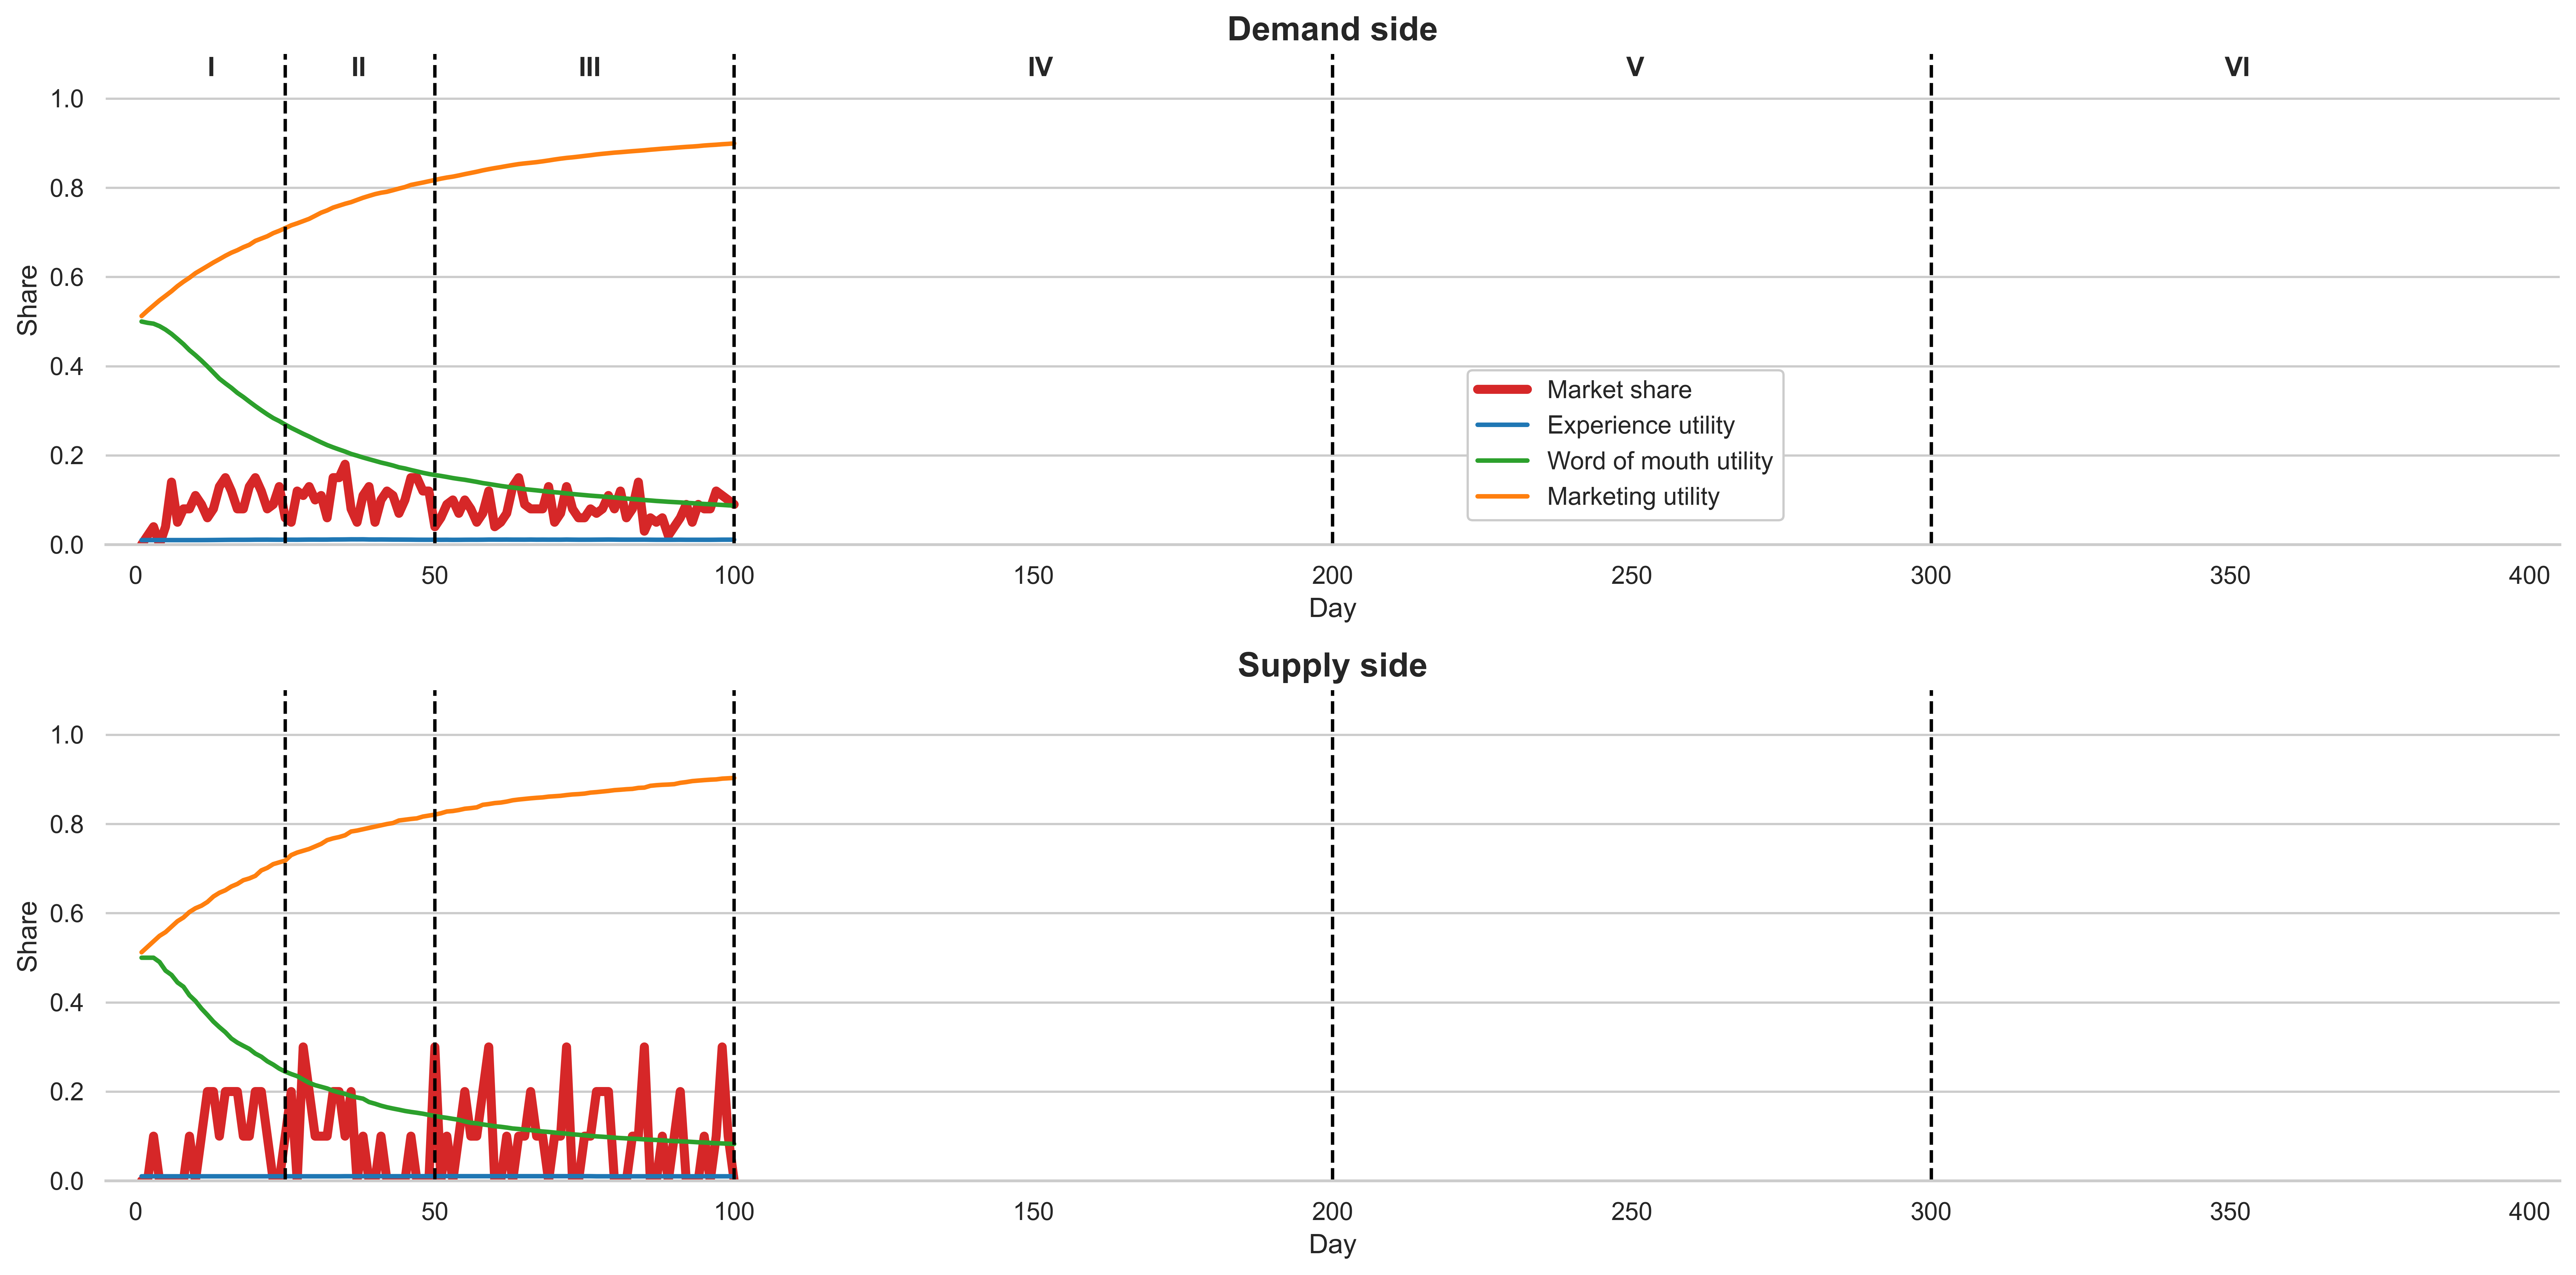

In [20]:
printSim(env.sim)